In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import (models, transforms)
import os
import utils
from pathlib import Path
import trainer
from torchinfo import summary
import time
import matplotlib.pyplot as plt
import numpy as np
import simplify
import torch.nn.utils.prune as prune

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/p3rzival/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
vit_default = utils.load_default_model()
loss_fn = nn.CrossEntropyLoss()
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit_transforms = pretrained_vit_weights.transforms()

In [3]:
prunning = 0.5997
pruned_model = utils.prune_vit(vit_default, prunning)
pruned_model.load_state_dict(torch.load(f"model/Pruning/ViT-PrunningDef{prunning:.2f}-Best.pht", weights_only=True))

<All keys matched successfully>

In [4]:
_, _, val_dl, _ = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=1)
loss_fn = nn.CrossEntropyLoss()

In [5]:
for parameter in pruned_model.parameters():
    parameter.requires_grad = False

In [6]:
#trainer.evaluate(pruned_model, val_dl, loss_fn, device)

Doing warm-up runs...
Ended warm-up, beginning true runs...


 22%|██▏       | 440/2000 [01:45<06:12,  4.18it/s]Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/usr/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-xs8y6zz0'
100%|██████████| 2000/2000 [08:14<00:00,  4.04it/s]


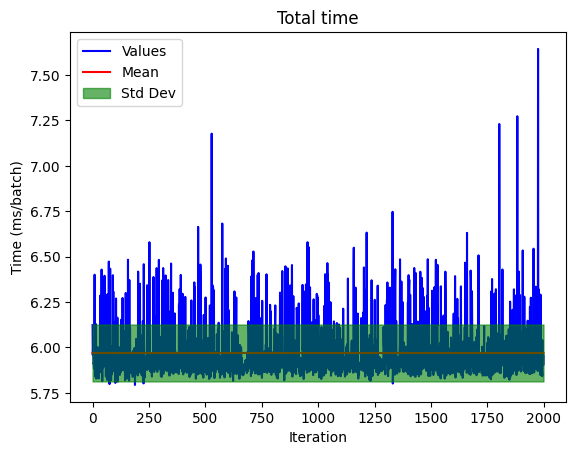

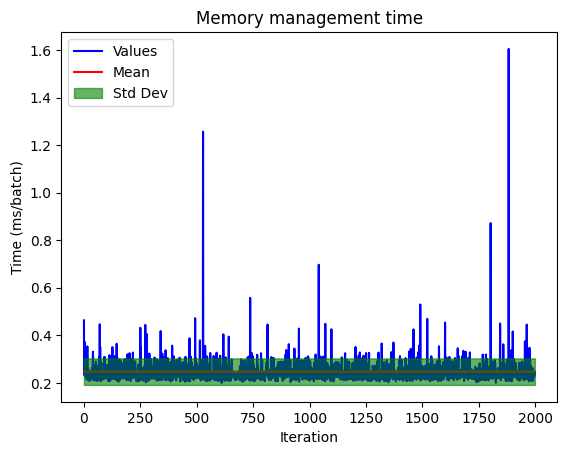

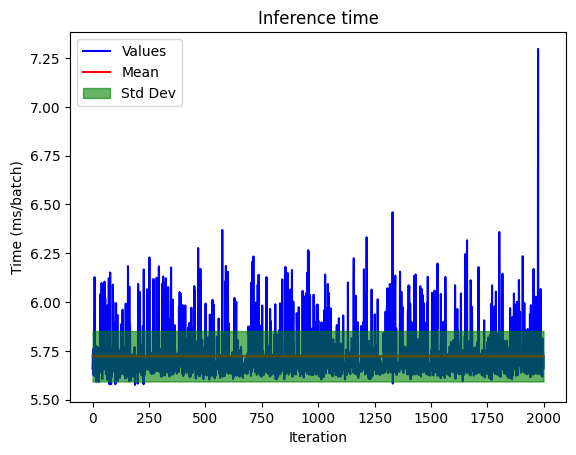

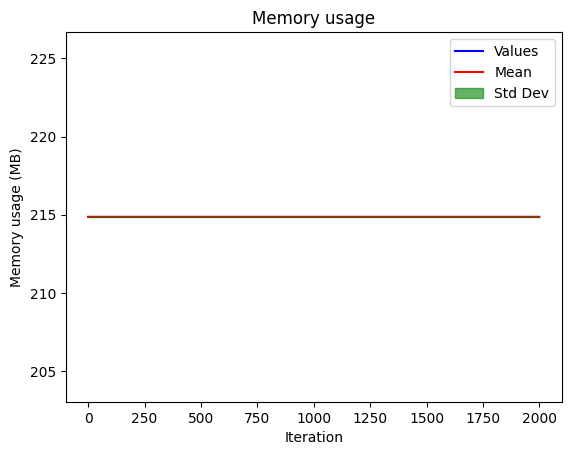

Mean total time over 2000 executions: 5.969652891159058 ms/batch 
Mean memory time over 2000 executions: 0.24713361263275146 ms/batch 
Mean inference time over 2000 executions: 5.722519278526306 ms/batch 
Mean memory over 2000 executions: 214.86279296875 MB


In [7]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
metrics = trainer.getMetrics(pruned_model, val_dl, device, num_times=2000, save_plots=True, model_title=f'ViT-Prunning-{round(prunning*100)}')